# Preprocessing

In [1]:
import os
import numpy as np
import argparse
from enum import Enum

# Constants definitions
MAX_SIMU_TOKENS = 16  
N_TRACKS = 4  # Number of "instrument" tracks
N_BARS = 2  # Assuming 2 bars for simplicity, adjust as needed
N_TIMESTEPS = 120  # Number of timesteps per bar, adjust as needed
RESOLUTION = 8  # Assuming 8 timesteps per beat, adjust as needed

# This enum contains edge type indices for each edge type
class EdgeTypes(Enum):
    TRACK = 0 # This has to be interpreted as the starting index
    ONSET = N_TRACKS
    NEXT = N_TRACKS + 1

# N_TRACKS track types + 1 onset edge type + 1 next edge type
N_EDGE_TYPES = N_TRACKS + 2

# Assuming these are defined elsewhere or simplifying for this example
N_DISCRETE_VALUES = 4
N_SAMPLES = 10

def generate_sample_data(num_samples, n_timesteps):
    np.random.seed(42)
    emotions = np.random.randint(0, N_DISCRETE_VALUES, (num_samples, n_timesteps))
    locations = np.random.randint(0, N_DISCRETE_VALUES, (num_samples, n_timesteps))
    activities = np.random.randint(0, N_DISCRETE_VALUES, (num_samples, n_timesteps))
    modes = np.random.randint(0, N_DISCRETE_VALUES, (num_samples, n_timesteps))
    return emotions, locations, activities, modes

def preprocess_sample_data(emotions, locations, activities, modes, dest_dir):
    num_samples = emotions.shape[0]
    n_timesteps = emotions.shape[1]
    window_size = N_BARS * 4 * RESOLUTION  # Calculate window size

    for sample_idx in range(num_samples):
        # Initialize tensors for this sample with the full length first
        full_c_tensor = np.zeros((N_TRACKS, n_timesteps, MAX_SIMU_TOKENS, 2), dtype=np.int16)
        full_s_tensor = np.zeros((N_TRACKS, n_timesteps), dtype=bool)

        # Populate the full tensors
        for t in range(n_timesteps):
            for track_idx, data in enumerate([emotions, locations, activities, modes]):
                value = data[sample_idx, t]
                full_c_tensor[track_idx, t, 0, 0] = value  # Pitch as emotion value
                full_c_tensor[track_idx, t, 0, 1] = 1  # Duration as 1 for simplicity
                full_s_tensor[track_idx, t] = True  # Note played at this timestep
        
        stride = window_size // 2

        # Windowing over time
        for start_idx in range(0, n_timesteps - window_size + 1, stride):
            c_tensor_segment = full_c_tensor[:, start_idx:start_idx + window_size, :, :]
            s_tensor_segment = full_s_tensor[:, start_idx:start_idx + window_size]

            # Save the tensors for this segment to an .npz file
            sample_filepath = os.path.join(dest_dir, f"sample_{sample_idx}_segment_{start_idx//stride}.npz")
            try:
                np.savez(sample_filepath, c_tensor=c_tensor_segment, s_tensor=s_tensor_segment)
                print(f"File saved: {sample_filepath}")
            except Exception as e:
                print(f"Failed to save {sample_filepath}: {e}")

In [2]:
import os

# Fixed directory
dest_dir = r'C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed'

# Ensure the destination directory exists
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Generate sample data
emotions, locations, activities, modes = generate_sample_data(N_SAMPLES, N_TIMESTEPS)

# Preprocess and save the sample data
preprocess_sample_data(emotions, locations, activities, modes, dest_dir)


File saved: C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed\sample_0_segment_0.npz
File saved: C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed\sample_0_segment_1.npz
File saved: C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed\sample_1_segment_0.npz
File saved: C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed\sample_1_segment_1.npz
File saved: C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed\sample_2_segment_0.npz
File saved: C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed\sample_2_segment_1.npz
File saved: C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed\sample_3_segment_0.npz
File saved: C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed\sample_3_segment_1.npz
File saved: C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed\sample_4_segment_0.npz
File saved: C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed\sample_4_segment_1.npz
File saved: C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed\sample_5_segment_0.npz

In [3]:
file_path = r'C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed\sample_0_segment_0.npz'

# Load the .npz file
data = np.load(file_path)

# Access the tensors
c_tensor = data['c_tensor']
s_tensor = data['s_tensor']

# Print their shapes
print(f'Shape of c_tensor: {c_tensor.shape}')
print(f'Shape of s_tensor: {s_tensor.shape}')

Shape of c_tensor: (4, 64, 16, 2)
Shape of s_tensor: (4, 64)


# Graph Construction

In [4]:
import itertools
import os

import torch
import numpy as np
from torch_geometric.data import Dataset
from torch_geometric.data import Data
from torch_geometric.data.collate import collate
from torch_geometric.data import Batch


def get_node_labels(s_tensor, ones_idxs):
    # Build a tensor which has node labels in place of each activation in the
    # stucture tensor
    labels = torch.zeros_like(s_tensor, dtype=torch.long, 
                              device=s_tensor.device)
    n_nodes = len(ones_idxs[0])
    labels[ones_idxs] = torch.arange(n_nodes, device=s_tensor.device)
    return labels


def get_track_edges(s_tensor, ones_idxs=None, node_labels=None):

    track_edges = []

    if ones_idxs is None:
        # Indices where the binary structure tensor is active
        ones_idxs = torch.nonzero(s_tensor, as_tuple=True)

    if node_labels is None:
        node_labels = get_node_labels(s_tensor, ones_idxs)

    # For each track, add direct and inverse edges between consecutive nodes
    for track in range(s_tensor.size(0)):
        # List of active timesteps in the current track
        tss = list(ones_idxs[1][ones_idxs[0] == track])
        edge_type = EdgeTypes.TRACK.value + track
        edges = [
            # Edge tuple: (u, v, type, ts_distance). Zip is used to obtain
            # consecutive active timesteps. Edges in different tracks have
            # different types.
            (node_labels[track, t1],
             node_labels[track, t2], edge_type, t2 - t1)
            for t1, t2 in zip(tss[:-1], tss[1:])
        ]
        inverse_edges = [(u, v, t, d) for (v, u, t, d) in edges]
        track_edges.extend(edges + inverse_edges)

    return torch.tensor(track_edges, dtype=torch.long)


def get_onset_edges(s_tensor, ones_idxs=None, node_labels=None):

    onset_edges = []
    edge_type = EdgeTypes.ONSET.value

    if ones_idxs is None:
        # Indices where the binary structure tensor is active
        ones_idxs = torch.nonzero(s_tensor, as_tuple=True)

    if node_labels is None:
        node_labels = get_node_labels(s_tensor, ones_idxs)

    # Add direct and inverse edges between nodes played in the same timestep
    for ts in range(s_tensor.size(1)):
        # List of active tracks in the current timestep
        tracks = list(ones_idxs[0][ones_idxs[1] == ts])
        # Obtain all possible pairwise combinations of active tracks
        combinations = list(itertools.combinations(tracks, 2))
        edges = [
            # Edge tuple: (u, v, type, ts_distance(=0)).
            (node_labels[track1, ts], node_labels[track2, ts], edge_type, 0)
            for track1, track2 in combinations
        ]
        inverse_edges = [(u, v, t, d) for (v, u, t, d) in edges]
        onset_edges.extend(edges + inverse_edges)

    return torch.tensor(onset_edges, dtype=torch.long)


def get_next_edges(s_tensor, ones_idxs=None, node_labels=None):

    next_edges = []
    edge_type = EdgeTypes.NEXT.value

    if ones_idxs is None:
        # Indices where the binary structure tensor is active
        ones_idxs = torch.nonzero(s_tensor, as_tuple=True)

    if node_labels is None:
        node_labels = get_node_labels(s_tensor, ones_idxs)

    # List of active timesteps
    tss = torch.nonzero(torch.any(s_tensor.bool(), dim=0)).squeeze()
    if tss.dim() == 0:
        return torch.tensor([], dtype=torch.long)

    for i in range(tss.size(0)-1):
        # Get consecutive active timesteps
        t1, t2 = tss[i], tss[i+1]
        # Get all the active tracks in the two timesteps
        t1_tracks = ones_idxs[0][ones_idxs[1] == t1]
        t2_tracks = ones_idxs[0][ones_idxs[1] == t2]

        # Combine the source and destination tracks, removing combinations with
        # the same source and destination track (since these represent track
        # edges).
        tracks_product = list(itertools.product(t1_tracks, t2_tracks))
        tracks_product = [(track1, track2)
                          for (track1, track2) in tracks_product
                          if track1 != track2]
        # Edge tuple: (u, v, type, ts_distance).
        edges = [(node_labels[track1, t1], node_labels[track2, t2],
                  edge_type, t2 - t1)
                 for track1, track2 in tracks_product]

        next_edges.extend(edges)

    return torch.tensor(next_edges, dtype=torch.long)


def get_track_features(s_tensor):

    # Indices where the binary structure tensor is active
    ones_idxs = torch.nonzero(s_tensor)

    n_nodes = len(ones_idxs)
    tracks = ones_idxs[:, 0]
    n_tracks = s_tensor.size(0)

    # The feature n_nodes x n_tracks tensor contains one-hot tracks
    # representations for each node
    features = torch.zeros((n_nodes, n_tracks))
    features[torch.arange(n_nodes), tracks] = 1

    return features

def custom_collate(data_list):
    batch = Batch.from_data_list(data_list)
    if hasattr(batch, 'batch'):
        batch.bars = batch.batch.clone()  # Optionally clone to ensure no accidental modification
    return batch


def graph_from_tensor(s_tensor):

    bars = []

    # Iterate over bars and construct a graph for each bar
    for i in range(s_tensor.size(0)):

        bar = s_tensor[i]

        # If the bar contains no activations, add a fake one to avoid having 
        # to deal with empty graphs
        if not torch.any(bar):
            bar[0, 0] = 1

        # Get edges from boolean activations
        track_edges = get_track_edges(bar)
        onset_edges = get_onset_edges(bar)
        next_edges = get_next_edges(bar)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        is_edgeless = (len(track_edges) == 0 and
                       len(onset_edges) == 0 and
                       len(next_edges) == 0)
        if not is_edgeless:
            edge_list = torch.cat([x for x in edges
                                   if torch.numel(x) > 0])

        # Adapt tensor to torch_geometric's Data
        # If no edges, add fake self-edge
        # edge_list[:, :2] contains source and destination node labels
        # edge_list[:, 2:] contains edge types and timestep distances
        edge_index = (edge_list[:, :2].t().contiguous() if not is_edgeless else
                      torch.LongTensor([[0], [0]]))
        attrs = (edge_list[:, 2:] if not is_edgeless else
                 torch.Tensor([[0, 0]]))

        # Add one hot timestep distance to edge attributes
        edge_attr = torch.zeros(attrs.size(0), s_tensor.shape[-1] + 1)
        edge_attr[:, 0] = attrs[:, 0]
        edge_attr[torch.arange(edge_attr.size(0)),
                   attrs.long()[:, 1] + 1] = 1
        # print(type(edge_attr))

        node_features = get_track_features(bar)
        is_drum = node_features[:, 0].bool()
        num_nodes = torch.sum(bar, dtype=torch.long)
        bars.append(Data(edge_index=edge_index, edge_attr=edge_attr,
                         num_nodes=num_nodes, node_features=node_features,
                         is_drum=is_drum).to(s_tensor.device))

    # Use custom collate function to merge all Data objects into a single Batch
    #graph = custom_collate(bars)

    # Manage the batch attribute as bars, if it exists
    #if hasattr(graph, 'batch'):
    #    graph.bars = graph.batch.clone()  # Cloning to ensure that original batch numbers are preserved
    #    # print("Bars attribute added to graph")

    #return graph

    # Merge the graphs corresponding to different bars into a single big graph
    graph, _, _ = collate(
        Data,
        data_list=bars,
        increment=True,
        add_batch=True
    )

    # Change bars assignment vector name (otherwise, Dataloader's collate
    # would overwrite graphs.batch)
    graph.bars = graph.batch

    return graph


In [5]:
import os
import numpy as np
import torch
from torch_geometric.data import Dataset

N_PITCH_TOKENS = 131
N_DUR_TOKENS = 99
D_TOKEN_PAIR = N_PITCH_TOKENS + N_DUR_TOKENS


class PolyphemusDataset(Dataset):
    def __init__(self, dir, n_bars=2):
        self.dir = dir
        self.files = [entry.path for entry in os.scandir(self.dir) if entry.is_file()]
        self.len = len(self.files)
        self.n_bars = n_bars

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # Load tensors
        sample_path = self.files[idx]  # Directly use the path string
        data = np.load(sample_path, allow_pickle = True)
        c_tensor = torch.tensor(data["c_tensor"], dtype=torch.long)
        s_tensor = torch.tensor(data["s_tensor"], dtype=torch.bool)

        # From (n_tracks x n_timesteps x ...)
        # to (n_bars x n_tracks x n_timesteps x ...)
        c_tensor = c_tensor.reshape(c_tensor.shape[0], self.n_bars, -1,
                                    c_tensor.shape[2], c_tensor.shape[3])
        c_tensor = c_tensor.permute(1, 0, 2, 3, 4)
        s_tensor = s_tensor.reshape(s_tensor.shape[0], self.n_bars, -1)
        s_tensor = s_tensor.permute(1, 0, 2)

        # From decimals to onehot (pitches)
        pitches = c_tensor[..., 0]
        onehot_p = torch.zeros(
            (pitches.shape[0]*pitches.shape[1]*pitches.shape[2]*pitches.shape[3],
             N_PITCH_TOKENS),
            dtype=torch.float32
        )
        onehot_p[torch.arange(0, onehot_p.shape[0]), pitches.reshape(-1)] = 1.
        onehot_p = onehot_p.reshape(pitches.shape[0], pitches.shape[1],
                                    pitches.shape[2], pitches.shape[3],
                                    N_PITCH_TOKENS)

        # From decimals to onehot (durations)
        durs = c_tensor[..., 1]
        onehot_d = torch.zeros(
            (durs.shape[0]*durs.shape[1]*durs.shape[2]*durs.shape[3],
             N_DUR_TOKENS),
            dtype=torch.float32
        )
        onehot_d[torch.arange(0, onehot_d.shape[0]), durs.reshape(-1)] = 1.
        onehot_d = onehot_d.reshape(durs.shape[0], durs.shape[1],
                                    durs.shape[2], durs.shape[3],
                                    N_DUR_TOKENS)

        # Concatenate pitches and durations
        c_tensor = torch.cat((onehot_p, onehot_d), dim=-1)

        # Build graph structure from structure tensor
        graph = graph_from_tensor(s_tensor)
        #print(type(graph.edge_attr))  # This should print <class 'torch.Tensor'>

        # Filter silences in order to get a sparse representation
        c_tensor = c_tensor.reshape(-1, c_tensor.shape[-2], c_tensor.shape[-1])
        c_tensor = c_tensor[s_tensor.reshape(-1).bool()]

        graph.c_tensor = c_tensor
        graph.s_tensor = s_tensor.float()

        return graph


In [6]:
import os
import torch
from torch_geometric.data import Dataset

# Assuming constants are defined somewhere in your codebase
N_PITCH_TOKENS = 131
N_DUR_TOKENS = 99

# Import the PolyphemusDataset class definition here

# Define the directory where your dataset is located
data_dir = r'C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed'

# Create an instance of the PolyphemusDataset
dataset = PolyphemusDataset(dir=data_dir, n_bars=2)

# Access the first item in the dataset to check edge_attr
graph = dataset[0]  # This will call the __getitem__ method


In [7]:
import os
import numpy as np
import torch
from torch_geometric.data import Dataset

# Constants for one-hot encoding
N_PITCH_TOKENS = 131
N_DUR_TOKENS = 99
D_TOKEN_PAIR = N_PITCH_TOKENS + N_DUR_TOKENS

# PolyphemusDataset class definition here (as provided in your question)

# Create an instance of the PolyphemusDataset
dir = r'C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed'
dataset = PolyphemusDataset(dir, n_bars=2)

# Load a sample from the dataset
sample_index = 0  # For example, load the first sample
graph = dataset[sample_index]

# Inspect the graph and its tensors
print("Graph:", graph)
print("Graph.c_tensor shape:", graph.c_tensor.shape)
print("Graph.s_tensor shape:", graph.s_tensor.shape)

Graph: Data(edge_index=[2, 2008], edge_attr=[2008, 33], num_nodes=256, node_features=[256, 4], is_drum=[256], batch=[256], ptr=[3], bars=[256], c_tensor=[256, 16, 230], s_tensor=[2, 4, 32])
Graph.c_tensor shape: torch.Size([256, 16, 230])
Graph.s_tensor shape: torch.Size([2, 4, 32])


# Model Architecture

In [8]:
from typing import Union, Tuple

import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torch_sparse import SparseTensor, masked_select_nnz
from torch_geometric.typing import OptTensor, Adj
from torch_geometric.nn.inits import reset
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Batch
from torch_geometric.nn.conv import RGCNConv

@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')


def masked_edge_attr(edge_attr, edge_mask):
    return edge_attr[edge_mask, :]


class GCL(RGCNConv):

    def __init__(self, in_channels, out_channels, num_relations, nn,
                 dropout=0.1, **kwargs):
        super().__init__(in_channels=in_channels, out_channels=out_channels,
                         num_relations=num_relations, **kwargs)
        self.nn = nn
        self.dropout = dropout

        self.reset_edge_nn()

    def reset_edge_nn(self):
        reset(self.nn)

    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None,
                edge_attr: OptTensor = None):
        # print(f"Before processing: x shape: {x.shape}, edge_index shape: {edge_index.shape}, edge_type shape: {edge_type.shape}, edge_attr shape: {edge_attr.shape}")
        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)
        weight = self.weight

        # Basis-decomposition
        if self.num_bases is not None:
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        # Block-diagonal-decomposition
        if self.num_blocks is not None:

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:
            # No regularization/Basis-decomposition
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                attr = masked_edge_attr(edge_attr, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size,
                                       edge_attr=attr)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias
        # print(f"After processing: Output shape: {out.shape}")
        return out

    def message(self, x_j: Tensor, edge_attr: Tensor) -> Tensor:

        # Use edge nn to compute weight tensor from edge attributes
        # (=onehot timestep distances between nodes)
        # print(f"Message: x_j shape: {x_j.shape}, edge_attr shape: {edge_attr.shape}")
        weights = self.nn(edge_attr)
        weights = weights[..., :self.in_channels_l]
        weights = weights.view(-1, self.in_channels_l)

        out = x_j * weights
        # print(f"Message output shape: {out.shape}")
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout, training=self.training)

        return out


class MLP(nn.Module):

    def __init__(self, input_dim=256, hidden_dim=256, output_dim=256,
                 num_layers=2, activation=True, dropout=0.1):
        super().__init__()

        self.layers = nn.ModuleList()

        if num_layers == 1:
            self.layers.append(nn.Linear(input_dim, output_dim))
        else:
            # Input layer (1) + Intermediate layers (n-2) + Output layer (1)
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            for _ in range(num_layers - 2):
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.Linear(hidden_dim, output_dim))

        self.activation = activation
        self.p = dropout

    def forward(self, x):
        for layer in self.layers:
            x = F.dropout(x, p=self.p, training=self.training)
            x = layer(x)
            if self.activation:
                x = F.relu(x)
        return x


class GCN(nn.Module):

    def __init__(self, input_dim=256, hidden_dim=256, n_layers=3,
                 num_relations=3, num_dists=32, batch_norm=False, dropout=0.1):
        super().__init__()

        self.layers = nn.ModuleList()
        self.norm_layers = nn.ModuleList()
        edge_nn = nn.Linear(num_dists, input_dim)
        self.batch_norm = batch_norm

        self.layers.append(GCL(input_dim, hidden_dim, num_relations, edge_nn))
        if self.batch_norm:
            self.norm_layers.append(BatchNorm(hidden_dim))

        for i in range(n_layers-1):
            self.layers.append(GCL(hidden_dim, hidden_dim,
                                   num_relations, edge_nn))
            if self.batch_norm:
                self.norm_layers.append(BatchNorm(hidden_dim))

        self.p = dropout

    def forward(self, data):

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # print(type(edge_attr))
        edge_type = edge_attr[:, 0]
        edge_attr = edge_attr[:, 1:]

        for i in range(len(self.layers)):
            # print(f"Layer {i}: Input shape: {x.shape}")
            residual = x
            x = F.dropout(x, p=self.p, training=self.training)
            x = self.layers[i](x, edge_index, edge_type, edge_attr)

            if self.batch_norm:
                x = self.norm_layers[i](x)

            x = F.relu(x)
            x = residual + x
            # print(f"Layer {i}: Output shape: {x.shape}")

        return x


class CNNEncoder(nn.Module):

    def __init__(self, output_dim=64, dense_dim=64, batch_norm=False,
                 dropout=0.1):
        super().__init__()

        # Convolutional layers
        if batch_norm:
            self.conv = nn.Sequential(
                # From (4 x 32) to (8 x 4 x 32)
                nn.Conv2d(1, 8, 3, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(True),
                # From (8 x 4 x 32) to (8 x 4 x 8)
                nn.MaxPool2d((1, 4), stride=(1, 4)),
                # From (8 x 4 x 8) to (16 x 4 x 8)
                nn.Conv2d(8, 16, 3, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(True)
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(1, 8, 3, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d((1, 4), stride=(1, 4)),
                nn.Conv2d(8, 16, 3, padding=1),
                nn.ReLU(True)
            )

        self.flatten = nn.Flatten(start_dim=1)

        # Linear layers
        self.lin = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(16 * 4 * 8, dense_dim),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(dense_dim, output_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.lin(x)
        return x


class CNNDecoder(nn.Module):

    def __init__(self, input_dim=64, dense_dim=64, batch_norm=False,
                 dropout=0.1):
        super().__init__()

        # Linear decompressors
        self.lin = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_dim, dense_dim),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(dense_dim, 16 * 4 * 8),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 4, 8))

        # Upsample and convolutional layers
        if batch_norm:
            self.conv = nn.Sequential(
                nn.Upsample(scale_factor=(1, 4), mode='nearest'),
                nn.Conv2d(16, 8, 3, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(True),
                nn.Conv2d(8, 1, 3, padding=1)
            )
        else:
            self.conv = nn.Sequential(
                nn.Upsample(scale_factor=(1, 4), mode='nearest'),
                nn.Conv2d(16, 8, 3, padding=1),
                nn.ReLU(True),
                nn.Conv2d(8, 1, 3, padding=1)
            )

    def forward(self, x):
        x = self.lin(x)
        x = self.unflatten(x)
        x = self.conv(x)
        x = x.unsqueeze(1)
        return x


class ContentEncoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        #self.device = device  # Store the device as an instance variable
        self.__dict__.update(kwargs)

        self.dropout_layer = nn.Dropout(p=self.dropout)

        # Pitch and duration embedding layers (separate layers for drums
        # and non drums)
        self.non_drums_pitch_emb = nn.Linear(N_PITCH_TOKENS, 
                                             self.d//2)
        self.drums_pitch_emb = nn.Linear(N_PITCH_TOKENS, self.d//2)
        self.dur_emb = nn.Linear(N_DUR_TOKENS, self.d//2)

        # Batch norm layers
        self.bn_non_drums = nn.BatchNorm1d(num_features=self.d//2)
        self.bn_drums = nn.BatchNorm1d(num_features=self.d//2)
        self.bn_dur = nn.BatchNorm1d(num_features=self.d//2)

        self.chord_encoder = nn.Linear(
            self.d * (MAX_SIMU_TOKENS-1), self.d)

        self.graph_encoder = GCN(
            dropout=self.dropout,
            input_dim=self.d,
            hidden_dim=self.d,
            n_layers=self.gnn_n_layers,
            num_relations=N_EDGE_TYPES,
            batch_norm=self.batch_norm
        )

        # Soft attention node-aggregation layer
        gate_nn = nn.Sequential(
            MLP(input_dim=self.d, output_dim=1, num_layers=1,
                activation=False, dropout=self.dropout),
            nn.BatchNorm1d(1)
        )
        self.graph_attention = GlobalAttention(gate_nn)

        self.bars_encoder = nn.Linear(self.n_bars * self.d, self.d)
    
    def forward(self, graph):
        c_tensor = graph.c_tensor

        # Discard SOS token
        c_tensor = c_tensor[:, 1:, :]

        # Get drums and non drums tensors
        drums = c_tensor[graph.is_drum]
        non_drums = c_tensor[torch.logical_not(graph.is_drum)]

        # Compute drums embeddings
        sz = drums.size()
        drums_pitch = self.drums_pitch_emb(
            drums[..., :N_PITCH_TOKENS])
        drums_pitch = self.bn_drums(drums_pitch.view(-1, self.d//2))
        drums_pitch = drums_pitch.view(sz[0], sz[1], self.d//2)
        drums_dur = self.dur_emb(drums[..., N_PITCH_TOKENS:])
        drums_dur = self.bn_dur(drums_dur.view(-1, self.d//2))
        drums_dur = drums_dur.view(sz[0], sz[1], self.d//2)
        drums = torch.cat((drums_pitch, drums_dur), dim=-1)
        # n_nodes x MAX_SIMU_TOKENS x d

        # Compute non drums embeddings
        sz = non_drums.size()
        non_drums_pitch = self.non_drums_pitch_emb(
            non_drums[..., :N_PITCH_TOKENS]
        )
        non_drums_pitch = self.bn_non_drums(non_drums_pitch.view(-1, self.d//2))
        non_drums_pitch = non_drums_pitch.view(sz[0], sz[1], self.d//2)
        non_drums_dur = self.dur_emb(non_drums[..., N_PITCH_TOKENS:])
        non_drums_dur = self.bn_dur(non_drums_dur.view(-1, self.d//2))
        non_drums_dur = non_drums_dur.view(sz[0], sz[1], self.d//2)
        non_drums = torch.cat((non_drums_pitch, non_drums_dur), dim=-1)
        # n_nodes x MAX_SIMU_TOKENS x d

        # Compute chord embeddings (drums and non drums)
        drums = self.chord_encoder(
            drums.view(-1, self.d * (MAX_SIMU_TOKENS-1))
        )
        non_drums = self.chord_encoder(
            non_drums.view(-1, self.d * (MAX_SIMU_TOKENS-1))
        )
        drums = F.relu(drums)
        non_drums = F.relu(non_drums)
        drums = self.dropout_layer(drums)
        non_drums = self.dropout_layer(non_drums)
        # n_nodes x d

        # Merge drums and non drums
        out = torch.zeros((c_tensor.size(0), self.d), device=self.device,
                          dtype=drums.dtype)
        out[graph.is_drum] = drums
        out[torch.logical_not(graph.is_drum)] = non_drums
        # n_nodes x d

        # Set initial graph node states to intermediate chord representations 
        # and pass through GCN
        graph.x = out
        graph.distinct_bars = graph.bars + self.n_bars*graph.batch
        out = self.graph_encoder(graph)
        # n_nodes x d

        # Aggregate final node states into bar encodings with soft attention
        with torch.cuda.amp.autocast(enabled=False):
            out = self.graph_attention(out, batch=graph.distinct_bars)
        # bs x n_bars x d

        out = out.view(-1, self.n_bars * self.d)
        # bs x (n_bars*d)
        z_c = self.bars_encoder(out)
        # bs x d
        
        return z_c


class StructureEncoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.cnn_encoder = CNNEncoder(
            dense_dim=self.d,
            output_dim=self.d,
            dropout=self.dropout,
            batch_norm=self.batch_norm
        )
        self.bars_encoder = nn.Linear(self.n_bars * self.d, self.d)
        # self.bars_encoder = nn.Linear(self.d, self.d)
    
    def forward(self, graph):
        s_tensor = graph.s_tensor
        # print(f"Initial s_tensor shape: {s_tensor.shape}")  # Initial shape: [bs, N_TRACKS, feature_dim]

        # Adjust the reshaping for CNN input
        # We assume feature_dim is the total dimension for each track, needing to be reshaped
        # to fit CNN expectations. If your CNN expects [batch_size, channels, height, width],
        # and here you interpret N_TRACKS as channels, your reshaping needs to reflect this.
        s_tensor_reshaped = s_tensor.view(-1, N_TRACKS , self.resolution* 4 )  # Reshape to include a channel dimension

        # Feed into CNN, the expected shape might need to adjust based on CNN's expected input dimensions
        out = self.cnn_encoder(s_tensor_reshaped)
        # print(f"After CNN encoder, out shape: {out.shape}")  # Check CNN output shape

        # Correct the reshaping to re-establish batch dimension
        out = out.view(-1, self.n_bars * self.d)  # Reshape to [bs, n_bars * d]
        # print(f"After view, out shape: {out.shape}")
        # print(f"Shape before linear layer: {out.shape}")
        z_s = self.bars_encoder(out)
        # print(f"Final z_s shape: {z_s.shape}")  # Expect [bs, d]

        return z_s


class Encoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.s_encoder = StructureEncoder(**kwargs)
        self.c_encoder = ContentEncoder(**kwargs)

        self.dropout_layer = nn.Dropout(p=self.dropout)

        # Linear layer that merges content and structure representations
        self.linear_merge = nn.Linear(2*self.d, self.d)
        self.bn_linear_merge = nn.BatchNorm1d(num_features=self.d)

        self.linear_mu = nn.Linear(self.d, self.d)
        self.linear_log_var = nn.Linear(self.d, self.d)

    def forward(self, graph):
        
        z_s = self.s_encoder(graph)
        z_c = self.c_encoder(graph)
        
        # Merge content and structure representations
        # print(f"z_c shape: {z_c.shape}")
        # print(f"z_s shape: {z_s.shape}")
        z_g = torch.cat((z_c, z_s), dim=1)
        z_g = self.dropout_layer(z_g)
        z_g = self.linear_merge(z_g)
        z_g = self.bn_linear_merge(z_g)
        z_g = F.relu(z_g)

        # Compute mu and log(std^2)
        z_g = self.dropout_layer(z_g)
        mu = self.linear_mu(z_g)
        log_var = self.linear_log_var(z_g)

        return mu, log_var


class StructureDecoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.bars_decoder = nn.Linear(self.d, self.d * self.n_bars)
        #self.bars_decoder = nn.Linear(self.d, self.d)
        self.cnn_decoder = CNNDecoder(
            input_dim=self.d,
            dense_dim=self.d,
            dropout=self.dropout,
            batch_norm=self.batch_norm
        )

    def forward(self, z_s):
        # z_s: bs x d
        out = self.bars_decoder(z_s)  # bs x (n_bars*d)
        # out = self.cnn_decoder(out)
        out = self.cnn_decoder(out.reshape(-1, self.d))
        out = out.view(z_s.size(0), self.n_bars, N_TRACKS, -1)
        return out


class ContentDecoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.bars_decoder = nn.Linear(self.d, self.d * self.n_bars)

        self.graph_decoder = GCN(
            dropout=self.dropout,
            input_dim=self.d,
            hidden_dim=self.d,
            n_layers=self.gnn_n_layers,
            num_relations=N_EDGE_TYPES,
            batch_norm=self.batch_norm
        )

        self.chord_decoder = nn.Linear(
            self.d, self.d*(MAX_SIMU_TOKENS-1))

        # Pitch and duration (un)embedding linear layers
        self.drums_pitch_emb = nn.Linear(self.d//2, N_PITCH_TOKENS)
        self.non_drums_pitch_emb = nn.Linear(
            self.d//2, N_PITCH_TOKENS)
        self.dur_emb = nn.Linear(self.d//2, N_DUR_TOKENS)

        self.dropout_layer = nn.Dropout(p=self.dropout)

    def forward(self, z_c, s):

        out = self.bars_decoder(z_c)  # bs x (n_bars*d)

        # Initialize node features with corresponding z_bar
        # and propagate with GNN
        s.distinct_bars = s.bars + self.n_bars*s.batch
        _, counts = torch.unique(s.distinct_bars, return_counts=True)
        out = out.view(-1, self.d)
        out = torch.repeat_interleave(out, counts, axis=0)  # n_nodes x d
        s.x = out
        out = self.graph_decoder(s)  # n_nodes x d

        out = self.chord_decoder(out)  # n_nodes x (MAX_SIMU_TOKENS*d)
        out = out.view(-1, MAX_SIMU_TOKENS-1, self.d)

        drums = out[s.is_drum]  # n_nodes_drums x MAX_SIMU_TOKENS x d
        non_drums = out[torch.logical_not(s.is_drum)]
        # n_nodes_non_drums x MAX_SIMU_TOKENS x d

        # Obtain final pitch and dur logits (softmax will be applied
        # outside forward)
        non_drums = self.dropout_layer(non_drums)
        drums = self.dropout_layer(drums)

        drums_pitch = self.drums_pitch_emb(drums[..., :self.d//2])
        drums_dur = self.dur_emb(drums[..., self.d//2:])
        drums = torch.cat((drums_pitch, drums_dur), dim=-1)
        # n_nodes_drums x MAX_SIMU_TOKENS x d_token

        non_drums_pitch = self.non_drums_pitch_emb(non_drums[..., :self.d//2])
        non_drums_dur = self.dur_emb(non_drums[..., self.d//2:])
        non_drums = torch.cat((non_drums_pitch, non_drums_dur), dim=-1)
        # n_nodes_non_drums x MAX_SIMU_TOKENS x d_token

        # Merge drums and non-drums in the final output tensor
        d_token = D_TOKEN_PAIR
        out = torch.zeros((s.num_nodes, MAX_SIMU_TOKENS-1, d_token),
                          device=self.device, dtype=drums.dtype)
        out[s.is_drum] = drums
        out[torch.logical_not(s.is_drum)] = non_drums

        return out


class Decoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.lin_decoder = nn.Linear(self.d, 2 * self.d)
        self.batch_norm = nn.BatchNorm1d(num_features=2*self.d)
        self.dropout = nn.Dropout(p=self.dropout)

        self.s_decoder = StructureDecoder(**kwargs)
        self.c_decoder = ContentDecoder(**kwargs)

        self.sigmoid_thresh = 0.5

    def _structure_from_binary(self, s_tensor):

        # Create graph structures for each batch
        s = []
        for i in range(s_tensor.size(0)):
            s.append(graph_from_tensor(s_tensor[i]))

        # Create batch of graphs from single graphs
        s = Batch.from_data_list(s, exclude_keys=['batch'])
        s = s.to(next(self.parameters()).device)

        return s

    def _binary_from_logits(self, s_logits):

        # Hard threshold instead of sampling gives more pleasant results
        s_tensor = torch.sigmoid(s_logits)
        s_tensor[s_tensor >= self.sigmoid_thresh] = 1
        s_tensor[s_tensor < self.sigmoid_thresh] = 0
        s_tensor = s_tensor.bool()
        
        # Avoid empty bars by creating a fake activation for each empty
        # (n_tracks x n_timesteps) bar matrix in position [0, 0]
        empty_mask = ~s_tensor.any(dim=-1).any(dim=-1)
        idxs = torch.nonzero(empty_mask, as_tuple=True)
        s_tensor[idxs + (0, 0)] = True

        return s_tensor

    def _structure_from_logits(self, s_logits):

        # Compute binary structure tensor from logits and build torch geometric
        # structure from binary tensor
        s_tensor = self._binary_from_logits(s_logits)
        s = self._structure_from_binary(s_tensor)

        return s

    def forward(self, z, s=None):

        # Obtain z_s and z_c from z
        z = self.lin_decoder(z)
        z = self.batch_norm(z)
        z = F.relu(z)
        z = self.dropout(z)  # bs x (2*d)
        z_s, z_c = z[:, :self.d], z[:, self.d:]

        # Obtain the tensor containing structure logits
        s_logits = self.s_decoder(z_s)

        if s is None:
            # Build torch geometric graph structure from structure logits.
            # This step involves non differentiable operations.
            # No gradients pass through here.
            s = self._structure_from_logits(s_logits.detach())

        # Obtain the tensor containing content logits
        c_logits = self.c_decoder(z_c, s)

        return s_logits, c_logits


class VAE(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.encoder = Encoder(**kwargs)
        self.decoder = Decoder(**kwargs)

    def forward(self, graph):

        # Encoder pass
        mu, log_var = self.encoder(graph)

        # Reparameterization trick
        z = torch.exp(0.5 * log_var)
        z = z * torch.randn_like(z)
        z = z + mu

        # Decoder pass
        out = self.decoder(z, graph)

        return out, mu, log_var


In [9]:
class PitchToken(Enum):
    SOS = 128
    EOS = 129
    PAD = 130


N_PITCH_TOKENS = 131
MAX_PITCH_TOKEN = 127


# Duration tokens have values in the range [0, 98]. Tokens from 0 to 95 have to
# be interpreted as durations from 1 to 96 timesteps.
class DurationToken(Enum):
    SOS = 96
    EOS = 97
    PAD = 98
    
def append_dict(dest_d, source_d):

    for k, v in source_d.items():
        dest_d[k].append(v)

def print_divider():
    print('—' * 40)

# Training

In [10]:
import time
import os
from statistics import mean
from collections import defaultdict

import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
import pprint
import math

#import constants
#from constants import PitchToken, DurationToken
#from utils import append_dict, print_divider


class StepBetaScheduler():
    def __init__(self, anneal_start, beta_max, step_size, anneal_end):
        self.anneal_start = anneal_start
        self.beta_max = beta_max
        self.step_size = step_size
        self.anneal_end = anneal_end

        self.update_steps = 0
        self.beta = 0
        n_steps = self.beta_max // self.step_size
        self.inc_every = (self.anneal_end-self.anneal_start) // n_steps

    def step(self):
        self.update_steps += 1

        if (self.update_steps >= self.anneal_start or
                self.update_steps < self.anneal_end):
            # If we are annealing, update beta according to current step
            curr_step = (self.update_steps-self.anneal_start) // self.inc_every
            self.beta = self.step_size * (curr_step+1)
            
        return self.beta


class ExpDecayLRScheduler():
    def __init__(self, optimizer, peak_lr, warmup_steps, final_lr_scale,
                 decay_steps):

        self.optimizer = optimizer
        self.peak_lr = peak_lr
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps

        # Find the decay factor needed to reach the specified
        # learning rate scale after decay_steps steps
        self.decay_factor = -math.log(final_lr_scale) / self.decay_steps

        self.update_steps = 0

    def set_lr(self, optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    def step(self):
        self.update_steps += 1

        if self.update_steps <= self.warmup_steps:
            self.lr = self.peak_lr
        else:
            # Decay lr exponentially
            steps_after_warmup = self.update_steps - self. warmup_steps
            self.lr = \
                self.peak_lr * math.exp(-self.decay_factor*steps_after_warmup)

        self.set_lr(self.optimizer, self.lr)

        return self.lr


class PolyphemusTrainer():

    def __init__(self, model_dir, model, optimizer, init_lr=1e-4,
                 lr_scheduler=None, beta_scheduler=None, device=None, 
                 print_every=1, save_every=1, eval_every=100, 
                 iters_to_accumulate=1, **kwargs):
        self.__dict__.update(kwargs)

        self.model_dir = model_dir
        self.model = model
        self.optimizer = optimizer
        self.init_lr = init_lr
        self.lr_scheduler = lr_scheduler
        self.beta_scheduler = beta_scheduler
        self.device = device if device is not None else torch.device("cpu")
        self.cuda = True if self.device.type == 'cuda' else False
        self.print_every = print_every
        self.save_every = save_every
        self.eval_every = eval_every
        self.iters_to_accumulate = iters_to_accumulate

        # Losses (ignoring PAD tokens)
        self.bce_unreduced = nn.BCEWithLogitsLoss(reduction='none')
        self.ce_p = nn.CrossEntropyLoss(ignore_index=PitchToken.PAD.value)
        self.ce_d = nn.CrossEntropyLoss(ignore_index=DurationToken.PAD.value)

        # Training stats
        self.tr_losses = defaultdict(list)
        self.tr_accuracies = defaultdict(list)
        self.val_losses = defaultdict(list)
        self.val_accuracies = defaultdict(list)
        self.lrs = []
        self.betas = []
        self.times = []

    def train(self, trainloader, validloader=None, epochs=100, early_exit=None):

        self.tot_batches = 0
        self.beta = 0
        self.min_val_loss = np.inf

        start = time.time()
        self.times.append(start)

        self.model.train()
        scaler = torch.cuda.amp.GradScaler() if self.cuda else None
        self.optimizer.zero_grad()
        progress_bar = tqdm(range(len(trainloader)))

        for epoch in range(epochs):
            self.cur_epoch = epoch
            for batch_idx, graph in enumerate(trainloader):
                self.cur_batch_idx = batch_idx

                # Move batch of graphs to device. Note: a single graph here
                # represents a bar in the original sequence.
                graph = graph.to(self.device)
                s_tensor, c_tensor = graph.s_tensor, graph.c_tensor

                with torch.cuda.amp.autocast(enabled=self.cuda):
                    # Forward pass to obtain mu, log(sigma^2), computed by the
                    # encoder, and structure and content logits, computed by the
                    # decoder
                    (s_logits, c_logits), mu, log_var = self.model(graph)

                    # Compute losses
                    tot_loss, losses = self._losses(
                        s_tensor, s_logits,
                        c_tensor, c_logits,
                        mu, log_var
                    )
                    tot_loss = tot_loss / self.iters_to_accumulate

                # Backpropagation
                if self.cuda:
                    scaler.scale(tot_loss).backward()
                else:
                    tot_loss.backward()

                # Update weights with accumulated gradients
                if (self.tot_batches + 1) % self.iters_to_accumulate == 0:

                    if self.cuda:
                        scaler.step(self.optimizer)
                        scaler.update()
                    else:
                        self.optimizer.step()

                    self.optimizer.zero_grad()

                    # Update lr and beta
                    if self.lr_scheduler is not None:
                        self.lr_scheduler.step()
                    if self.beta_scheduler is not None:
                        self.beta_scheduler.step()

                # Compute accuracies
                accs = self._accuracies(
                    s_tensor, s_logits,
                    c_tensor, c_logits,
                    graph.is_drum
                )

                # Update the stats
                append_dict(self.tr_losses, losses)
                append_dict(self.tr_accuracies, accs)
                last_lr = (self.lr_scheduler.lr
                           if self.lr_scheduler is not None else self.init_lr)
                self.lrs.append(last_lr)
                self.betas.append(self.beta)
                now = time.time()
                self.times.append(now)

                # Print stats
                if (self.tot_batches + 1) % self.print_every == 0:
                    print("Training on batch {}/{} of epoch {}/{} complete."
                          .format(batch_idx+1,
                                  len(trainloader),
                                  epoch+1,
                                  epochs))
                    self._print_stats()
                    print_divider()

                # Eval on VL every `eval_every` gradient updates
                if (validloader is not None and
                        (self.tot_batches + 1) % self.eval_every == 0):

                    # Evaluate on VL
                    print("\nEvaluating on validation set...\n")
                    val_losses, val_accuracies = self.evaluate(validloader)

                    # Update stats
                    append_dict(self.val_losses, val_losses)
                    append_dict(self.val_accuracies, val_accuracies)

                    print("Val losses:")
                    print(val_losses)
                    print("Val accuracies:")
                    print(val_accuracies)

                    # Save model if VL loss (tot) reached a new minimum
                    # Example check before accessing 'tot'
                    if 'tot' in val_losses:
                        tot_loss = val_losses['tot']
                    else:
                        # Handle the missing key, e.g., set a default value or raise a more informative error
                        tot_loss = 0  # or some default value
                        print("Key 'tot' not found in val_losses. Setting tot_loss to 0.")

                    if tot_loss < self.min_val_loss:
                        print("\nValidation loss improved.")
                        print("Saving new best model to disk...\n")
                        self._save_model('best_model')
                        self.min_val_loss = tot_loss

                    self.model.train()

                progress_bar.update(1)

                # Save model and stats on disk
                if (self.save_every > 0 and
                        (self.tot_batches + 1) % self.save_every == 0):
                    self._save_model('checkpoint')

                # Stop prematurely if early_exit is set and reached
                if (early_exit is not None and
                        (self.tot_batches + 1) > early_exit):
                    break

                self.tot_batches += 1

        end = time.time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Training completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
              .format(int(hours), int(minutes), seconds))

        self._save_model('checkpoint')

    def evaluate(self, loader):
        print(f"Starting evaluation with {len(loader)} batches...")
        losses = defaultdict(list)
        accs = defaultdict(list)

        self.model.eval()
        progress_bar = tqdm(range(len(loader)))

        with torch.no_grad():
            for _, graph in enumerate(loader):

                # Get the inputs and move them to device
                graph = graph.to(self.device)
                s_tensor, c_tensor = graph.s_tensor, graph.c_tensor

                with torch.cuda.amp.autocast():
                    # Forward pass, get the reconstructions
                    (s_logits, c_logits), mu, log_var = self.model(graph)

                    _, losses_b = self._losses(
                        s_tensor, s_logits,
                        c_tensor, c_logits,
                        mu, log_var
                    )

                accs_b = self._accuracies(
                    s_tensor, s_logits,
                    c_tensor, c_logits,
                    graph.is_drum
                )

                # Save losses and accuracies
                append_dict(losses, losses_b)
                append_dict(accs, accs_b)

                progress_bar.update(1)

        # Compute avg losses and accuracies
        avg_losses = {}
        for k, l in losses.items():
            avg_losses[k] = mean(l)

        avg_accs = {}
        for k, l in accs.items():
            avg_accs[k] = mean(l)

        return avg_losses, avg_accs

    def _losses(self, s_tensor, s_logits, c_tensor, c_logits, mu, log_var):

        # Do not consider SOS token
        c_tensor = c_tensor[..., 1:, :]
        c_logits = c_logits.reshape(-1, c_logits.size(-1))
        c_tensor = c_tensor.reshape(-1, c_tensor.size(-1))

        # Reshape logits to match s_tensor dimensions:
        # n_graphs (in batch) x n_tracks x n_timesteps
        s_logits = s_tensor.reshape(-1, *s_logits.shape[2:])

        # Binary structure tensor loss (binary cross entropy)
        s_loss = self.bce_unreduced(
            s_logits.view(-1), s_tensor.view(-1).float())
        s_loss = torch.mean(s_loss)

        # Content tensor loss (pitches)
        # argmax is used to obtain token ids from onehot rep
        pitch_logits = c_logits[:, :N_PITCH_TOKENS]
        pitch_true = c_tensor[:, :N_PITCH_TOKENS].argmax(dim=1)
        pitch_loss = self.ce_p(pitch_logits, pitch_true)

        # Content tensor loss (durations)
        dur_logits = c_logits[:, N_PITCH_TOKENS:]
        dur_true = c_tensor[:, N_PITCH_TOKENS:].argmax(dim=1)
        dur_loss = self.ce_d(dur_logits, dur_true)

        # Kullback-Leibler divergence loss
        # Derivation in Kingma, Diederik P., and Max Welling. "Auto-encoding
        # variational bayes." (2013), Appendix B.
        # (https://arxiv.org/pdf/1312.6114.pdf)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(),
                                    dim=1)
        kld_loss = torch.mean(kld_loss)

        # Reconstruction loss and total loss
        rec_loss = pitch_loss + dur_loss + s_loss
        tot_loss = rec_loss + self.beta*kld_loss

        losses = {
            'tot': tot_loss.item(),
            'pitch': pitch_loss.item(),
            'dur': dur_loss.item(),
            'structure': s_loss.item(),
            'reconstruction': rec_loss.item(),
            'kld': kld_loss.item(),
            'beta*kld': self.beta*kld_loss.item()
        }

        return tot_loss, losses

    def _accuracies(self, s_tensor, s_logits, c_tensor, c_logits, is_drum):

        # Do not consider SOS token
        c_tensor = c_tensor[..., 1:, :]

        # Reshape logits to match s_tensor dimensions:
        # n_graphs (in batch) x n_tracks x n_timesteps
        s_logits = s_tensor.reshape(-1, *s_logits.shape[2:])

        # Note accuracy considers both pitches and durations
        note_acc = self._note_accuracy(c_logits, c_tensor)

        pitch_acc = self._pitch_accuracy(c_logits, c_tensor)

        # Compute pitch accuracies for drums and non drums separately
        pitch_acc_drums = self._pitch_accuracy(
            c_logits, c_tensor, drums=True, is_drum=is_drum
        )
        pitch_acc_non_drums = self._pitch_accuracy(
            c_logits, c_tensor, drums=False, is_drum=is_drum
        )

        dur_acc = self._duration_accuracy(c_logits, c_tensor)

        s_acc = self._structure_accuracy(s_logits, s_tensor)
        s_precision = self._structure_precision(s_logits, s_tensor)
        s_recall = self._structure_recall(s_logits, s_tensor)
        s_f1 = (2*s_recall*s_precision / (s_recall+s_precision))

        accs = {
            'note': note_acc.item(),
            'pitch': pitch_acc.item(),
            'pitch_drums': pitch_acc_drums.item(),
            'pitch_non_drums': pitch_acc_non_drums.item(),
            'dur': dur_acc.item(),
            's_acc': s_acc.item(),
            's_precision': s_precision.item(),
            's_recall': s_recall.item(),
            's_f1': s_f1.item()
        }

        return accs

    def _pitch_accuracy(self, c_logits, c_tensor, drums=None, is_drum=None):

        # When drums is None, just compute the global pitch accuracy without
        # distinguishing between drum and non drum pitches
        if drums is not None:
            if drums:
                c_logits = c_logits[is_drum]
                c_tensor = c_tensor[is_drum]
            else:
                c_logits = c_logits[torch.logical_not(is_drum)]
                c_tensor = c_tensor[torch.logical_not(is_drum)]

        # Apply softmax to obtain pitch reconstructions
        pitch_rec = c_logits[..., :N_PITCH_TOKENS]
        pitch_rec = F.softmax(pitch_rec, dim=-1)
        pitch_rec = torch.argmax(pitch_rec, dim=-1)

        pitch_true = c_tensor[..., :N_PITCH_TOKENS]
        pitch_true = torch.argmax(pitch_true, dim=-1)

        # Do not consider PAD tokens when computing accuracies
        not_pad = (pitch_true != PitchToken.PAD.value)

        correct = (pitch_rec == pitch_true)
        correct = torch.logical_and(correct, not_pad)

        return torch.sum(correct) / torch.sum(not_pad)

    def _duration_accuracy(self, c_logits, c_tensor):

        # Apply softmax to obtain reconstructed durations
        dur_rec = c_logits[..., N_PITCH_TOKENS:]
        dur_rec = F.softmax(dur_rec, dim=-1)
        dur_rec = torch.argmax(dur_rec, dim=-1)

        dur_true = c_tensor[..., N_PITCH_TOKENS:]
        dur_true = torch.argmax(dur_true, dim=-1)

        # Do not consider PAD tokens when computing accuracies
        not_pad = (dur_true != DurationToken.PAD.value)

        correct = (dur_rec == dur_true)
        correct = torch.logical_and(correct, not_pad)

        return torch.sum(correct) / torch.sum(not_pad)

    def _note_accuracy(self, c_logits, c_tensor):

        # Apply softmax to obtain pitch reconstructions
        pitch_rec = c_logits[..., :N_PITCH_TOKENS]
        pitch_rec = F.softmax(pitch_rec, dim=-1)
        pitch_rec = torch.argmax(pitch_rec, dim=-1)

        pitch_true = c_tensor[..., :N_PITCH_TOKENS]
        pitch_true = torch.argmax(pitch_true, dim=-1)

        not_pad_p = (pitch_true != PitchToken.PAD.value)

        correct_p = (pitch_rec == pitch_true)
        correct_p = torch.logical_and(correct_p, not_pad_p)

        dur_rec = c_logits[..., N_PITCH_TOKENS:]
        dur_rec = F.softmax(dur_rec, dim=-1)
        dur_rec = torch.argmax(dur_rec, dim=-1)

        dur_true = c_tensor[..., N_PITCH_TOKENS:]
        dur_true = torch.argmax(dur_true, dim=-1)

        not_pad_d = (dur_true != DurationToken.PAD.value)

        correct_d = (dur_rec == dur_true)
        correct_d = torch.logical_and(correct_d, not_pad_d)

        note_accuracy = torch.sum(
            torch.logical_and(correct_p, correct_d)) / torch.sum(not_pad_p)

        return note_accuracy

    def _structure_accuracy(self, s_logits, s_tensor):

        s_logits = torch.sigmoid(s_logits)
        s_logits[s_logits < 0.5] = 0
        s_logits[s_logits >= 0.5] = 1

        return torch.sum(s_logits == s_tensor) / s_tensor.numel()

    def _structure_precision(self, s_logits, s_tensor):

        s_logits = torch.sigmoid(s_logits)
        s_logits[s_logits < 0.5] = 0
        s_logits[s_logits >= 0.5] = 1

        tp = torch.sum(s_tensor[s_logits == 1])

        return tp / torch.sum(s_logits)

    def _structure_recall(self, s_logits, s_tensor):

        s_logits = torch.sigmoid(s_logits)
        s_logits[s_logits < 0.5] = 0
        s_logits[s_logits >= 0.5] = 1

        tp = torch.sum(s_tensor[s_logits == 1])

        return tp / torch.sum(s_tensor)

    def _save_model(self, filename):

        path = os.path.join(self.model_dir, filename)
        print("Saving model to disk...")

        torch.save({
            'epoch': self.cur_epoch,
            'batch': self.cur_batch_idx,
            'tot_batches': self.tot_batches,
            'betas': self.betas,
            'min_val_loss': self.min_val_loss,
            'print_every': self.print_every,
            'save_every': self.save_every,
            'eval_every': self.eval_every,
            'lrs': self.lrs,
            'tr_losses': self.tr_losses,
            'tr_accuracies': self.tr_accuracies,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, path)

        print("The model has been successfully saved.")

    def _print_stats(self):

        hours, rem = divmod(self.times[-1]-self.times[0], 3600)
        minutes, seconds = divmod(rem, 60)
        print("Elapsed time from start (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
              .format(int(hours), int(minutes), seconds))

        # Take mean of the last non-printed batches for each loss and accuracy
        avg_losses = {}
        for k, l in self.tr_losses.items():
            v = mean(l[-self.print_every:])
            avg_losses[k] = round(v, 2)

        avg_accs = {}
        for k, l in self.tr_accuracies.items():
            v = mean(l[-self.print_every:])
            avg_accs[k] = round(v, 2)

        print("Losses:")
        pprint.pprint(avg_losses, indent=2)

        print("Accuracies:")
        pprint.pprint(avg_accs, indent=2)


C:\Users\s222445\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from prettytable import PrettyTable
import random
import argparse
import os
import json
import uuid

import torch
import os
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import torch.optim as optim


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)



def print_params(model):

    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0

    for name, parameter in model.named_parameters():

        if not parameter.requires_grad:
            continue

        param = parameter.numel()
        table.add_row([name, param])
        total_params += param

    print(table)
    print(f"Total Trainable Parameters: {total_params}")

    return total_params

In [12]:
import os
import json
import uuid

import torch
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
# Ensure you have imported PolyphemusDataset, VAE, set_seed, print_params, print_divider, PolyphemusTrainer, ExpDecayLRScheduler, StepBetaScheduler correctly

# Configuration and setup
dataset_dir = r'C:\Users\s222445\Spatiotemporal GNN Thesis\preprocessed'
output_dir = r'C:\Users\s222445\Spatiotemporal GNN Thesis\output'
config_file = r'C:\Users\s222445\Spatiotemporal GNN Thesis\training.json'
model_name = 'testing_continuous'  # or None to use a UUID
save_every = 10
print_every = 1
eval_flag = True  # Set to False if you don't want to perform evaluation
eval_every = 10  
use_gpu = False
gpu_id = 0
num_workers = 0
tr_split = 0.7
vl_split = 0.1
max_epochs = 5
seed = 42  # or None

# Set seed for reproducibility
if seed is not None:
    set_seed(seed)

# Device setup
device = torch.device("cuda" if use_gpu else "cpu")
#if use_gpu:
#    torch.cuda.set_device(gpu_id)

# Load training configuration from JSON file
print(f"Loading the configuration file {config_file}...")
with open(config_file, 'r') as f:
    training_config = json.load(f)

n_bars = training_config['model']['n_bars']
batch_size = training_config['batch_size']

# Prepare datasets and dataloaders
print("Preparing datasets and dataloaders...")
dataset = PolyphemusDataset(dataset_dir, n_bars)

tr_len = int(tr_split * len(dataset))
vl_len = int(vl_split * len(dataset)) if eval_flag else 0
ts_len = len(dataset) - tr_len - vl_len
lengths = (tr_len, vl_len, ts_len) if eval_flag else (tr_len, len(dataset) - tr_len)

split = random_split(dataset, lengths)
tr_set, vl_set = split[0], (split[1] if eval_flag else None)

trainloader = DataLoader(tr_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validloader = DataLoader(vl_set, batch_size=batch_size, shuffle=False, num_workers=num_workers) if eval_flag else None

# Model setup
model_dir = os.path.join(output_dir, model_name or str(uuid.uuid1()))
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=False)

print(f"Creating the model and moving it to {device} device...")
vae = VAE(**training_config['model'], device=device).to(device)
print_params(vae)

# Optimizer and schedulers setup
optimizer = optim.Adam(vae.parameters(), **training_config['optimizer'])
lr_scheduler = ExpDecayLRScheduler(optimizer=optimizer, **training_config['lr_scheduler'])
beta_scheduler = StepBetaScheduler(**training_config['beta_scheduler'])

# Save configuration
config_path = os.path.join(model_dir, 'configuration.json')
with open(config_path, 'w') as f:
    json.dump(training_config, f)

# Training
print("Starting training...")
trainer = PolyphemusTrainer(
    model_dir=model_dir,
    model=vae,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    beta_scheduler=beta_scheduler,
    save_every=save_every,
    print_every=print_every,
    eval_every=eval_every,
    device=device
)
trainer.train(trainloader, validloader=validloader, epochs=max_epochs)

Loading the configuration file C:\Users\s222445\Spatiotemporal GNN Thesis\training.json...
Preparing datasets and dataloaders...
Creating the model and moving it to cpu device...


C:\Users\s222445\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


+-------------------------------------------------------------+------------+
|                           Modules                           | Parameters |
+-------------------------------------------------------------+------------+
|         encoder.s_encoder.cnn_encoder.conv.0.weight         |     72     |
|          encoder.s_encoder.cnn_encoder.conv.0.bias          |     8      |
|         encoder.s_encoder.cnn_encoder.conv.1.weight         |     8      |
|          encoder.s_encoder.cnn_encoder.conv.1.bias          |     8      |
|         encoder.s_encoder.cnn_encoder.conv.4.weight         |    1152    |
|          encoder.s_encoder.cnn_encoder.conv.4.bias          |     16     |
|         encoder.s_encoder.cnn_encoder.conv.5.weight         |     16     |
|          encoder.s_encoder.cnn_encoder.conv.5.bias          |     16     |
|          encoder.s_encoder.cnn_encoder.lin.1.weight         |   262144   |
|           encoder.s_encoder.cnn_encoder.lin.1.bias          |    512     |

 14%|█▍        | 1/7 [00:03<00:18,  3.08s/it]

Training on batch 1/7 of epoch 1/5 complete.
Elapsed time from start (h:m:s): 00:00:03.08
Losses:
{ 'beta*kld': 0.0,
  'dur': 5.66,
  'kld': 53.79,
  'pitch': 5.19,
  'reconstruction': 11.17,
  'structure': 0.31,
  'tot': 11.17}
Accuracies:
{ 'dur': 0.0,
  'note': 0.0,
  'pitch': 0.03,
  'pitch_drums': 0.04,
  'pitch_non_drums': 0.03,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


 29%|██▊       | 2/7 [00:05<00:14,  2.88s/it]

Training on batch 2/7 of epoch 1/5 complete.
Elapsed time from start (h:m:s): 00:00:05.83
Losses:
{ 'beta*kld': 0.0,
  'dur': 5.6,
  'kld': 56.81,
  'pitch': 5.16,
  'reconstruction': 11.07,
  'structure': 0.31,
  'tot': 11.07}
Accuracies:
{ 'dur': 0.0,
  'note': 0.0,
  'pitch': 0.03,
  'pitch_drums': 0.02,
  'pitch_non_drums': 0.03,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


 43%|████▎     | 3/7 [00:08<00:11,  2.87s/it]

Training on batch 3/7 of epoch 1/5 complete.
Elapsed time from start (h:m:s): 00:00:08.68
Losses:
{ 'beta*kld': 0.0,
  'dur': 4.25,
  'kld': 53.9,
  'pitch': 4.02,
  'reconstruction': 8.58,
  'structure': 0.31,
  'tot': 8.58}
Accuracies:
{ 'dur': 0.05,
  'note': 0.01,
  'pitch': 0.17,
  'pitch_drums': 0.05,
  'pitch_non_drums': 0.21,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


 57%|█████▋    | 4/7 [00:11<00:08,  2.73s/it]

Training on batch 4/7 of epoch 1/5 complete.
Elapsed time from start (h:m:s): 00:00:11.19
Losses:
{ 'beta*kld': 0.0,
  'dur': 2.98,
  'kld': 53.92,
  'pitch': 2.95,
  'reconstruction': 6.24,
  'structure': 0.31,
  'tot': 6.24}
Accuracies:
{ 'dur': 0.38,
  'note': 0.15,
  'pitch': 0.44,
  'pitch_drums': 0.05,
  'pitch_non_drums': 0.57,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


 71%|███████▏  | 5/7 [00:14<00:05,  2.77s/it]

Training on batch 5/7 of epoch 1/5 complete.
Elapsed time from start (h:m:s): 00:00:14.04
Losses:
{ 'beta*kld': 0.0,
  'dur': 1.82,
  'kld': 54.03,
  'pitch': 2.07,
  'reconstruction': 4.2,
  'structure': 0.31,
  'tot': 4.2}
Accuracies:
{ 'dur': 0.75,
  'note': 0.52,
  'pitch': 0.69,
  'pitch_drums': 0.09,
  'pitch_non_drums': 0.89,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


 86%|████████▌ | 6/7 [00:17<00:02,  2.84s/it]

Training on batch 6/7 of epoch 1/5 complete.
Elapsed time from start (h:m:s): 00:00:17.01
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.93,
  'kld': 54.53,
  'pitch': 1.42,
  'reconstruction': 2.66,
  'structure': 0.31,
  'tot': 2.66}
Accuracies:
{ 'dur': 0.98,
  'note': 0.75,
  'pitch': 0.77,
  'pitch_drums': 0.1,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


100%|██████████| 7/7 [00:19<00:00,  2.89s/it]

Training on batch 7/7 of epoch 1/5 complete.
Elapsed time from start (h:m:s): 00:00:20.00
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.39,
  'kld': 54.9,
  'pitch': 1.01,
  'reconstruction': 1.71,
  'structure': 0.31,
  'tot': 1.71}
Accuracies:
{ 'dur': 1.0,
  'note': 0.81,
  'pitch': 0.81,
  'pitch_drums': 0.23,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


8it [00:22,  2.89s/it]                       

Training on batch 1/7 of epoch 2/5 complete.
Elapsed time from start (h:m:s): 00:00:22.89
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.14,
  'kld': 55.22,
  'pitch': 0.76,
  'reconstruction': 1.21,
  'structure': 0.31,
  'tot': 1.21}
Accuracies:
{ 'dur': 1.0,
  'note': 0.86,
  'pitch': 0.86,
  'pitch_drums': 0.45,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


9it [00:25,  2.87s/it]

Training on batch 2/7 of epoch 2/5 complete.
Elapsed time from start (h:m:s): 00:00:25.71
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.05,
  'kld': 51.58,
  'pitch': 0.56,
  'reconstruction': 0.93,
  'structure': 0.31,
  'tot': 0.93}
Accuracies:
{ 'dur': 1.0,
  'note': 0.91,
  'pitch': 0.91,
  'pitch_drums': 0.64,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————
Training on batch 3/7 of epoch 2/5 complete.
Elapsed time from start (h:m:s): 00:00:28.16
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.02,
  'kld': 55.89,
  'pitch': 0.4,
  'reconstruction': 0.73,
  'structure': 0.31,
  'tot': 0.73}
Accuracies:
{ 'dur': 1.0,
  'note': 0.96,
  'pitch': 0.96,
  'pitch_drums': 0.84,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


C:\Users\s222445\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Val losses:
{'tot': 1.2931205034255981, 'pitch': 0.7541825175285339, 'dur': 0.22567637264728546, 'structure': 0.31326165795326233, 'reconstruction': 1.2931205034255981, 'kld': 8.15030574798584, 'beta*kld': 0.0}
Val accuracies:
{'note': 0.9791666865348816, 'pitch': 0.9791666865348816, 'pitch_drums': 0.9166666865348816, 'pitch_non_drums': 1.0, 'dur': 1.0, 's_acc': 1.0, 's_precision': 1.0, 's_recall': 1.0, 's_f1': 1.0}

Validation loss improved.
Saving new best model to disk...

Saving model to disk...


10it [00:29,  3.30s/it]

The model has been successfully saved.
Saving model to disk...
The model has been successfully saved.


11it [00:35,  3.89s/it]

Training on batch 4/7 of epoch 2/5 complete.
Elapsed time from start (h:m:s): 00:00:35.21
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.01,
  'kld': 51.61,
  'pitch': 0.26,
  'reconstruction': 0.58,
  'structure': 0.31,
  'tot': 0.58}
Accuracies:
{ 'dur': 1.0,
  'note': 0.99,
  'pitch': 0.99,
  'pitch_drums': 0.95,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


12it [00:38,  3.77s/it]

Training on batch 5/7 of epoch 2/5 complete.
Elapsed time from start (h:m:s): 00:00:38.70
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 54.58,
  'pitch': 0.16,
  'reconstruction': 0.48,
  'structure': 0.31,
  'tot': 0.48}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 0.98,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


13it [00:42,  3.67s/it]

Training on batch 6/7 of epoch 2/5 complete.
Elapsed time from start (h:m:s): 00:00:42.15
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 54.57,
  'pitch': 0.09,
  'reconstruction': 0.4,
  'structure': 0.31,
  'tot': 0.4}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


14it [00:45,  3.60s/it]

Training on batch 7/7 of epoch 2/5 complete.
Elapsed time from start (h:m:s): 00:00:45.56
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 54.25,
  'pitch': 0.04,
  'reconstruction': 0.36,
  'structure': 0.31,
  'tot': 0.36}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


15it [00:48,  3.49s/it]

Training on batch 1/7 of epoch 3/5 complete.
Elapsed time from start (h:m:s): 00:00:48.81
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 54.94,
  'pitch': 0.02,
  'reconstruction': 0.34,
  'structure': 0.31,
  'tot': 0.34}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


16it [00:52,  3.44s/it]

Training on batch 2/7 of epoch 3/5 complete.
Elapsed time from start (h:m:s): 00:00:52.13
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 53.49,
  'pitch': 0.01,
  'reconstruction': 0.33,
  'structure': 0.31,
  'tot': 0.33}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


17it [00:56,  3.60s/it]

Training on batch 3/7 of epoch 3/5 complete.
Elapsed time from start (h:m:s): 00:00:56.11
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 55.68,
  'pitch': 0.01,
  'reconstruction': 0.32,
  'structure': 0.31,
  'tot': 0.32}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


18it [01:01,  4.05s/it]

Training on batch 4/7 of epoch 3/5 complete.
Elapsed time from start (h:m:s): 00:01:01.21
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 56.63,
  'pitch': 0.0,
  'reconstruction': 0.32,
  'structure': 0.31,
  'tot': 0.32}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


19it [01:05,  4.22s/it]

Training on batch 5/7 of epoch 3/5 complete.
Elapsed time from start (h:m:s): 00:01:05.81
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 53.07,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————
Training on batch 6/7 of epoch 3/5 complete.
Elapsed time from start (h:m:s): 00:01:09.66
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 54.89,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Val losses:
{'tot': 0.32058408856391907, 'pitch': 0.006891996134072542, 'dur': 0.0004304362228140235, 'structure': 0.31326165795326233, 'reconstruction': 0.32058408856391907, 'kld': 40.243751525878906, 'beta*kld': 0.0}
Val accuracies:
{'note': 1.0, 'pitch': 1.0, 'pitch_drums': 1.0, 'pitch_non_drums': 1.0, 'dur': 1.0, 's_acc': 1.0, 's_precision': 1.0, 's_recall': 1.0, 's_f1': 1.0}

Validation loss improved.
Saving new best model to disk...

Saving model to disk...


20it [01:11,  4.75s/it]

The model has been successfully saved.
Saving model to disk...
The model has been successfully saved.


21it [01:15,  4.43s/it]

Training on batch 7/7 of epoch 3/5 complete.
Elapsed time from start (h:m:s): 00:01:15.47
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 54.25,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


22it [01:18,  4.00s/it]

Training on batch 1/7 of epoch 4/5 complete.
Elapsed time from start (h:m:s): 00:01:18.49
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 52.81,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


23it [01:21,  3.76s/it]

Training on batch 2/7 of epoch 4/5 complete.
Elapsed time from start (h:m:s): 00:01:21.70
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 55.11,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


24it [01:24,  3.40s/it]

Training on batch 3/7 of epoch 4/5 complete.
Elapsed time from start (h:m:s): 00:01:24.25
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 52.85,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


25it [01:26,  3.15s/it]

Training on batch 4/7 of epoch 4/5 complete.
Elapsed time from start (h:m:s): 00:01:26.81
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 54.24,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


26it [01:29,  2.95s/it]

Training on batch 5/7 of epoch 4/5 complete.
Elapsed time from start (h:m:s): 00:01:29.29
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 55.79,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


27it [01:32,  2.93s/it]

Training on batch 6/7 of epoch 4/5 complete.
Elapsed time from start (h:m:s): 00:01:32.17
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 56.91,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


28it [01:35,  3.19s/it]

Training on batch 7/7 of epoch 4/5 complete.
Elapsed time from start (h:m:s): 00:01:35.98
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 54.18,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


29it [01:39,  3.36s/it]

Training on batch 1/7 of epoch 5/5 complete.
Elapsed time from start (h:m:s): 00:01:39.72
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 55.23,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————
Training on batch 2/7 of epoch 5/5 complete.
Elapsed time from start (h:m:s): 00:01:43.56
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 55.0,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————

Evaluating on validation set...

Starting evaluation with 1 batches...


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Val losses:
{'tot': 0.3132694959640503, 'pitch': 7.604952770634554e-06, 'dur': 2.2328450199893268e-07, 'structure': 0.31326165795326233, 'reconstruction': 0.3132694959640503, 'kld': 141.52072143554688, 'beta*kld': 0.0}
Val accuracies:
{'note': 1.0, 'pitch': 1.0, 'pitch_drums': 1.0, 'pitch_non_drums': 1.0, 'dur': 1.0, 's_acc': 1.0, 's_precision': 1.0, 's_recall': 1.0, 's_f1': 1.0}

Validation loss improved.
Saving new best model to disk...

Saving model to disk...


30it [01:46,  4.26s/it]

The model has been successfully saved.
Saving model to disk...
The model has been successfully saved.


31it [01:50,  4.33s/it]

Training on batch 3/7 of epoch 5/5 complete.
Elapsed time from start (h:m:s): 00:01:50.59
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 51.77,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


32it [01:53,  3.97s/it]

Training on batch 4/7 of epoch 5/5 complete.
Elapsed time from start (h:m:s): 00:01:53.73
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 56.18,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


33it [01:57,  3.80s/it]

Training on batch 5/7 of epoch 5/5 complete.
Elapsed time from start (h:m:s): 00:01:57.12
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 54.21,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


34it [02:00,  3.61s/it]

Training on batch 6/7 of epoch 5/5 complete.
Elapsed time from start (h:m:s): 00:02:00.29
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 55.43,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————


35it [02:03,  3.48s/it]

Training on batch 7/7 of epoch 5/5 complete.
Elapsed time from start (h:m:s): 00:02:03.47
Losses:
{ 'beta*kld': 0.0,
  'dur': 0.0,
  'kld': 53.31,
  'pitch': 0.0,
  'reconstruction': 0.31,
  'structure': 0.31,
  'tot': 0.31}
Accuracies:
{ 'dur': 1.0,
  'note': 1.0,
  'pitch': 1.0,
  'pitch_drums': 1.0,
  'pitch_non_drums': 1.0,
  's_acc': 1.0,
  's_f1': 1.0,
  's_precision': 1.0,
  's_recall': 1.0}
————————————————————————————————————————
Training completed in (h:m:s): 00:02:03.47
Saving model to disk...


35it [02:04,  3.55s/it]

The model has been successfully saved.


In [13]:
import os

from matplotlib import pyplot as plt
import matplotlib as mpl
import torch

def plot_structure(s_tensor, save_dir=None, name='structure'):

    lines_linewidth = 1
    axes_linewidth = 1
    font_size = 14
    fformat = 'svg'
    dpi = 200

    n_bars = s_tensor.shape[0]
    figsize = (3 * n_bars, 3)

    n_timesteps = s_tensor.size(2)
    resolution = n_timesteps // 4
    s_tensor = s_tensor.permute(1, 0, 2)
    s_tensor = s_tensor.reshape(s_tensor.shape[0], -1)

    with mpl.rc_context({'lines.linewidth': lines_linewidth,
                         'axes.linewidth': axes_linewidth,
                         'font.size': font_size}):

        plt.figure(figsize=figsize)
        plt.pcolormesh(s_tensor, edgecolors='k', linewidth=1)
        ax = plt.gca()

        plt.xticks(range(0, s_tensor.shape[1], resolution),
                   range(1, 4*n_bars + 1))
        plt.yticks(range(0, s_tensor.shape[0]), constants.TRACKS)

        ax.invert_yaxis()

        if save_dir:
            plt.savefig(os.path.join(save_dir, name + "." + fformat),
                        format=fformat, dpi=dpi)
    
    
def plot_stats(stat_names, stats_tr, stats_val=None, eval_every=None, 
               labels=None, rx=None, ry=None):

    for i, stat in enumerate(stat_names):

        label = stat if not labels else labels[i]

        plt.plot(range(1, len(stats_tr[stat])+1), stats_tr[stat],
                label=label+' (TR)')

        if stats_val:
            plt.plot(range(eval_every, len(stats_tr[stat])+1, eval_every),
                    stats_val[stat], '.', label=label+' (VL)')

    plt.grid()

    plt.ylim(ry) if ry else plt.ylim(0)
    plt.xlim(rx) if rx else plt.xlim(0)

    plt.legend()


# Dictionary that maps loss statistic name to plot label 
loss_labels = {
    'tot': 'Total Loss',
    'structure': 'Structure',
    'pitch': 'Pitches',
    'dur': 'Duration',
    'reconstruction': 'Reconstruction Term',
    'kld': 'KLD',
    'beta*kld': 'beta * KLD'
}


def plot_losses(model_dir, losses, plot_val=False):
    
    checkpoint_path = os.path.join(model_dir, 'checkpoint')
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    labels = [loss_labels[loss] for loss in losses]
    
    tr_losses = checkpoint['tr_losses']
    val_losses = checkpoint['val_losses'] if plot_val == True else None
    eval_every = checkpoint['eval_every'] if plot_val == True else None

    plot_stats(losses, tr_losses, stats_val=val_losses,
               eval_every=eval_every, labels=labels, rx=(0))
    

# Dictionary that maps accuracy statistic name to plot label 
accuracy_labels = {
    's_acc': 'Struct. Accuracy',
    's_precision': 'Struct. Precision',
    's_recall': 'Struct. Recall',
    's_f1': 'Struct. F1',
    'pitch': 'Pitch Accuracy',
    'pitch_drums': 'Pitch Accuracy (Drums)',
    'pitch_non_drums': 'Pitch Accuracy (Non Drums)',
    'dur': 'Duration Accuracy',
    'note': 'Note Accuracy'
}


def plot_accuracies(model_dir, accuracies, plot_val=False):
    
    checkpoint_path = os.path.join(model_dir, 'checkpoint')
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    labels = [accuracy_labels[accuracy] for accuracy in accuracies]
    
    tr_accuracies = checkpoint['tr_accuracies']
    val_accuracies = checkpoint['val_accuracies'] if plot_val == True else None
    eval_every = checkpoint['eval_every'] if plot_val == True else None

    plot_stats(accuracies, tr_accuracies, stats_val=val_accuracies,
               eval_every=eval_every, labels=labels, ry=(0, 1))

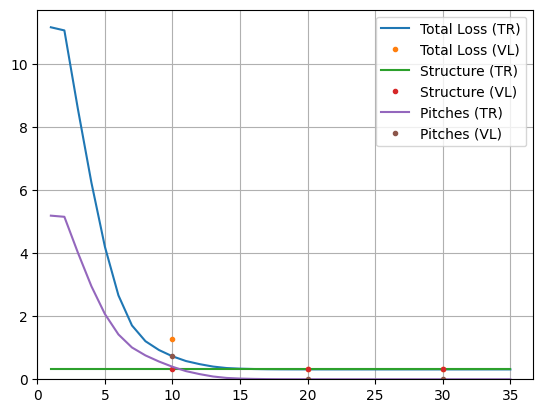

In [14]:
# Assuming your model's directory is 'model_dir'
plot_losses(model_dir='output/testing_continuous', losses=['tot', 'structure', 'pitch'], plot_val=True)

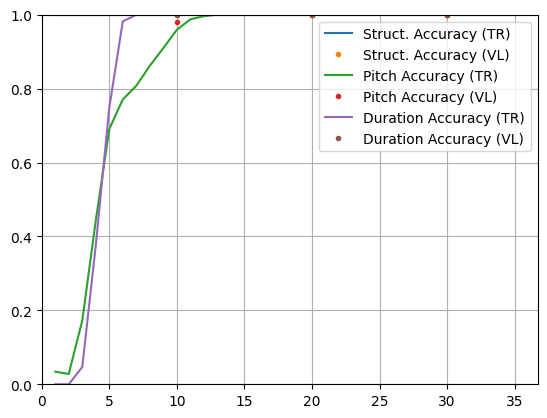

In [15]:
# Assuming your model's directory is 'model_dir'
plot_accuracies(model_dir='output/testing_continuous', accuracies=['s_acc', 'pitch', 'dur'], plot_val=True)

# Plotting Reconstruction

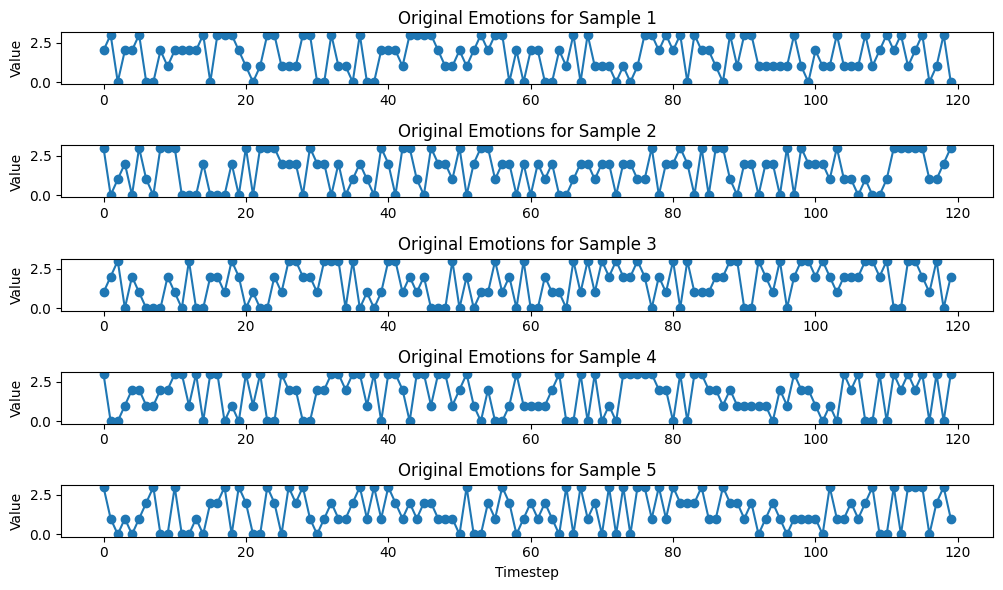

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_original_data(data, title='Original Data', samples=5):
    plt.figure(figsize=(10, 6))
    for i in range(samples):
        plt.subplot(samples, 1, i+1)
        plt.plot(data[i], marker='o', linestyle='-')
        plt.title(f"{title} for Sample {i+1}")
        plt.ylabel('Value')
    plt.xlabel('Timestep')
    plt.tight_layout()
    plt.show()

plot_original_data(emotions, title='Original Emotions')
